In [1]:
# add project root to path
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# For Matrix Operations
import sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
from scipy import stats

# tda
import gudhi
from VineyardFinal import vineyard, vdist, persistence, fD, fL

# plotting
from matplotlib import pyplot as plt
import matplotlib as mpl

# Rc Params
custom_rc = {
    # font general
    'font.family': 'Times New Roman',

    # ticks
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.labelsize': 14,


    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.labelsize': 12,


    # title
    'axes.titlesize': 18,
    'axes.titleweight': 'bold', 
    'axes.titlecolor': 'black', 

    # axes
    'axes.labelsize': 16,
    'axes.labelweight': 'normal',  
    'axes.labelcolor': 'black',      

    # legend
    'legend.fontsize': 14,  
}

pd.options.mode.chained_assignment = None
plt.rcParams['text.usetex'] = False
mpl.rcParams.update(custom_rc)

# My Dependencies
# Getting rid of pesky degree-0 graph warnings 
import warnings
warnings.filterwarnings('ignore', message='Found islands', category=UserWarning)


INFINITY = 1e6
n = 100

# VERSIONS USED
# !pip install gerrychain==0.2.22
# !pip install shapely==2.0.2
# !pip install geopandas==0.12.2
#################

In [20]:
###### outDir ######
outDir = "../figs/mnist"
os.makedirs(outDir, exist_ok=True)

###### Data preprocessing ###### 
X, y = fetch_openml('Mnist_784', version = 1, return_X_y = True, as_frame = False)

X = X.reshape(X.shape[0],28,28)

Sixes = X[np.where(y == '6')]
Nines = X[np.where(y == '9')]

no_samples = 100
dimension = 1

Sixes = Sixes[:no_samples]
Nines = Nines[:no_samples]

CombinedArray = np.concatenate((Sixes, Nines), axis = 0)

###### Vineyard distance ###### 
VineyardDistances = np.zeros((CombinedArray.shape[0], CombinedArray.shape[0]))

for i in range(CombinedArray.shape[0]):
    for j in range(i+1,CombinedArray.shape[0]):
        VineyardDistances[i,j] = vdist(vineyard(CombinedArray[i], CombinedArray[j], dim = 1, nt = 25),fD,fL)

VineyardDistances += np.transpose(VineyardDistances)

###### W1 distance ###### 
W1Distances = np.zeros((len(CombinedArray), len(CombinedArray)))

CombinedPDS = [persistence(Img,dimension = dimension) for Img in  CombinedArray]

for i in range(len(CombinedArray)):

    for j in range(len(CombinedArray)):

        if i <= j:
            W1Distances[i,j] = gudhi.hera.wasserstein_distance(CombinedPDS[i], CombinedPDS[j])
            
W1Distances += W1Distances.transpose()

## minmax normalization ##
W1Distances = (W1Distances - np.min(W1Distances)) / (np.max(W1Distances) - np.min(W1Distances))
VineyardDistances = (VineyardDistances - np.min(VineyardDistances)) / (np.max(VineyardDistances) - np.min(VineyardDistances))

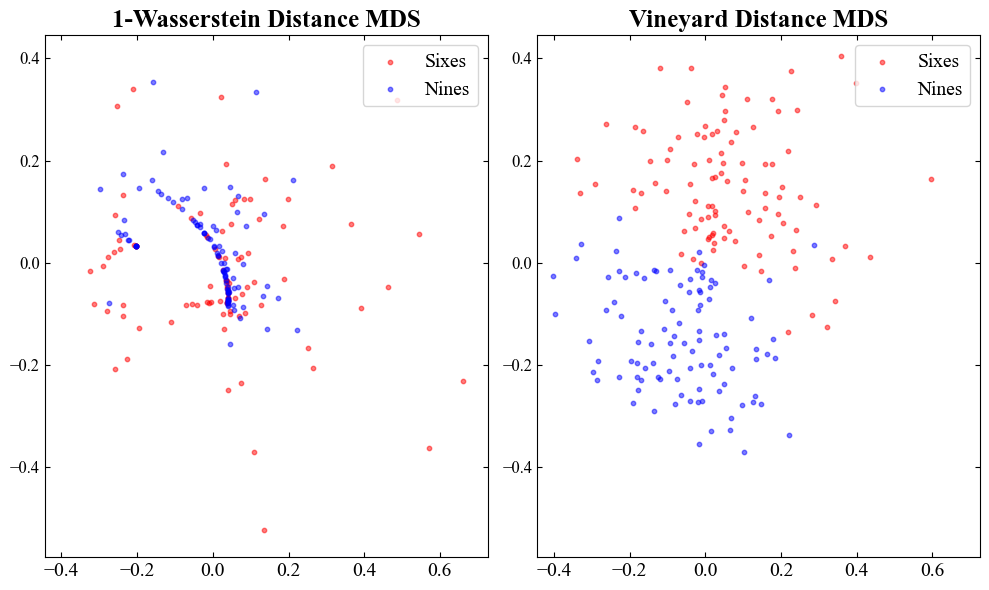

In [21]:
VineyardMdsEmbedding = MDS(n_components = 2, metric = True, dissimilarity = 'precomputed', random_state = 32).fit_transform(VineyardDistances)
W1MdsEmbedding = MDS(n_components = 2, metric = True, dissimilarity = 'precomputed', random_state = 32).fit_transform(W1Distances)

x_min = min(np.min(W1MdsEmbedding[:, 0]), np.min(VineyardMdsEmbedding[:, 0])) * 1.1
x_max = max(np.max(W1MdsEmbedding[:, 0]), np.max(VineyardMdsEmbedding[:, 0])) * 1.1
y_min = min(np.min(W1MdsEmbedding[:, 1]), np.min(VineyardMdsEmbedding[:, 1])) * 1.1
y_max = max(np.max(W1MdsEmbedding[:, 1]), np.max(VineyardMdsEmbedding[:, 1])) * 1.1

fig, ax = plt.subplots(1,2, figsize = (10,6))

## MDS using Wasserstein Distances ##
scatter_sixes = ax[0].scatter(W1MdsEmbedding[:len(Sixes), 0], W1MdsEmbedding[:len(Sixes), 1], c='red', alpha = 0.5, s=10, label='Sixes')
scatter_nines = ax[0].scatter(W1MdsEmbedding[len(Sixes):, 0], W1MdsEmbedding[len(Sixes):, 1], c='blue', alpha = 0.5, s=10, label='Nines')

ax[0].legend(loc = 'upper right')
ax[0].set_title('1-Wasserstein Distance MDS')
ax[0].set_xlim([x_min, x_max])  # Set x-axis limits
ax[0].set_ylim([y_min, y_max])  # Set y-axis limits

## MDS using Vineyard Distances ##
scatter_sixes = ax[1].scatter(VineyardMdsEmbedding[:len(Sixes), 0], VineyardMdsEmbedding[:len(Sixes), 1], c='red', alpha = 0.5, s=10, label='Sixes')
scatter_nines = ax[1].scatter(VineyardMdsEmbedding[len(Sixes):, 0], VineyardMdsEmbedding[len(Sixes):, 1], c='blue', alpha = 0.5, s=10, label='Nines')

ax[1].legend(loc = 'upper right')
ax[1].set_title('Vineyard Distance MDS')
ax[1].set_xlim([x_min, x_max])  # Set x-axis limits
ax[1].set_ylim([y_min, y_max])  # Set y-axis limits

plt.tight_layout()
plt.savefig(os.path.join(outDir, "sixes_and_nines.png"), dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()